# House Prices - Advanced Regression Techniques
*Predict sales prices and practice feature engineering, RFs, and gradient boosting*


### Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.impute import SimpleImputer 
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

### Load Datasets

In [2]:
train_data = pd.read_csv('https://raw.githubusercontent.com/keivanipchihagh/Kaggle-Competitions/main/House%20Prices%20-%20Advanced%20Regression%20Techniques/Datasets/Raw%20Datasets/train.csv')
test_data = pd.read_csv('https://raw.githubusercontent.com/keivanipchihagh/Kaggle-Competitions/main/House%20Prices%20-%20Advanced%20Regression%20Techniques/Datasets/Raw%20Datasets/test.csv')

train_data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Data Processing

In [3]:
# Drop 'Id' columns since it's not helpful with the prediction
train_data.drop(columns = ['Id'], inplace = True)
test_data.drop(columns = ['Id'], inplace = True)

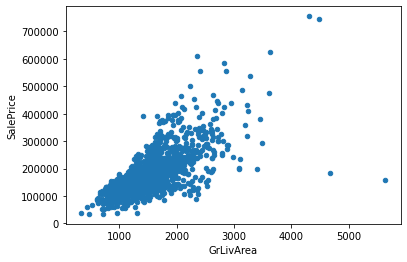

In [4]:
# Spotting outliers
train_data[['GrLivArea', 'SalePrice']].plot.scatter(x = 'GrLivArea', y = 'SalePrice');
train_data  = train_data[train_data['GrLivArea'] < 5000]

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


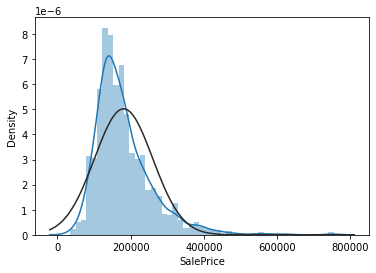

In [5]:
# Normalize SalePrice
sns.distplot(train_data['SalePrice'] , fit = st.norm)
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

In [6]:
# Combine both datasets into one
y_train = train_data['SalePrice'].values
all_data = pd.concat((train_data, test_data)).reset_index(drop = True)
all_data.drop(columns = ['SalePrice'], inplace = True)

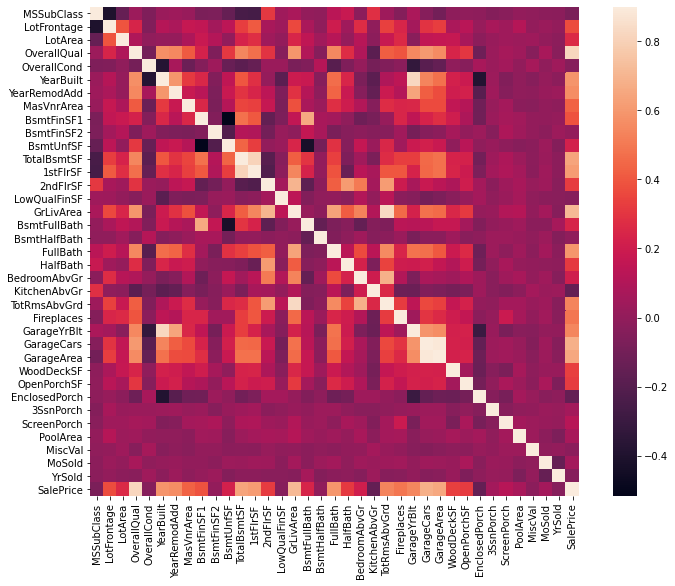

In [7]:
# Correlation map to see how features are correlated with 'SalePrice'
corrmat = train_data.corr()
plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.9, square = True)

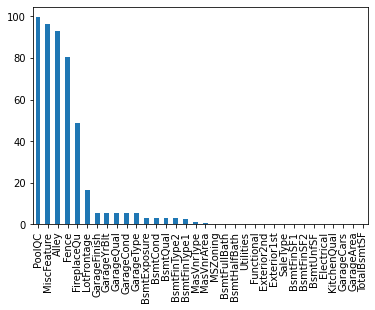

In [8]:
# Draw a plot indicating missing entries in each column
missing = all_data.isnull().sum() / all_data.shape[0] * 100
missing = missing[missing > 0]
missing.sort_values(inplace = True, ascending = False)
missing.plot.bar()

# We can fill the rest of the columns with the appropriate replacements

# PoolQC, MiscFeature, Alley, Fence, FireplaceQu - NA means Not-Existing, so we can fill it with 'None'
for column in ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']:
  all_data[column] = all_data[column].fillna('None')

# LotFrontage
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# GarageYrBlt, GarageArea, GarageCars - NA means Not-Existing, so we can fill it with '0'
for column in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    all_data[column] = all_data[column].fillna(0)

# GarageType, GarageFinish, GarageQual, GarageCond - NA means Not-Existing, so we can fill it with 'None'
for column in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    all_data[column] = all_data[column].fillna('None')

# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF ,TotalBsmtSF, BsmtFullBath, BsmtHalfBath - NA means Not-Existing, so we can fill it with '0'
for column in ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']:
    all_data[column] = all_data[column].fillna(0)

# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 - NA means Not-Existing, so we can fill it with 'None'
for column in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    all_data[column] = all_data[column].fillna('None')

# MasVnrType, MasVnrArea
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

# MSZoning
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

# Utilities
all_data = all_data.drop(columns = ['Utilities'])

# Functional, Electrical, KitchenQual, Exterior1st, Exterior2nd, SaleType
all_data["Functional"] = all_data["Functional"].fillna("Typ")
for column in ['Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
  all_data[column] = all_data[column].fillna(all_data[column].mode()[0])

# MSSubClass
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [9]:
# Feature Engineer
for column in ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold', 'GarageYrBlt', 'YearRemodAdd', 'YearBuilt']:
  all_data[column] = all_data[column].apply(str)

In [10]:
# Imputing categorical features
columns_to_encode = all_data.dtypes[all_data.dtypes == 'object'].index

# process columns, apply LabelEncoder to categorical features
for column in columns_to_encode:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[column].values)) 
    all_data[column] = lbl.transform(list(all_data[column].values))

In [11]:
# Splitting data
train = all_data[:len(train_data)]
test = all_data[len(train_data):]

# Save processed Datasets
train.to_csv('train.csv')
test.to_csv('test.csv')

### Modeling

In [12]:
# Define validation strategies
def MSE_cv(model, n_folds = 5):
    cv = KFold(n_splits = n_folds, shuffle = True).get_n_splits(train.values)
    MSE = -cross_val_score(model, train.values, y_train, scoring = "neg_mean_squared_error", cv = cv)
    return MSE

def MSE(y, y_pred):
    return mean_squared_error(y, y_pred)

In [ ]:
# Define the model
XGB_model = XGBRegressor(learning_rate = 0.01, n_estimators = 2000, silent = True)

# Model Error
print('Mean Err:', MSE_cv(XGB_model, 5).mean(), sep =' ')

In [15]:
# Train the moel
XGB_model.fit(train, y_train)

# Get predictins
predictions = XGB_model.predict(train)

# Test prediction Error
print('Mean Err:', MSE(predictions, y_train).mean(), sep =' ')

Mean Err: 0.005095284718822238


### Submision

In [16]:
predictions = XGB_model.predict(test)

submission = pd.DataFrame()
submission['Id'] = [i for i in range(len(test))]
submission['SalePrice'] = predictions

submission.to_csv('submission.csv')